In [1]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import product

In [2]:
def generate_board(alpha = 0.9, size=8):
    a = np.full([size,size], ' ')

    pieces = ["♔", "♚"] + list(np.random.permutation(["♕","♗","♗","♘","♘","♖","♖"] + 
                                                     ["♛","♝","♝","♞","♞","♜","♜"]))
    k = 0

    pawns = np.random.permutation(["♙","♙","♙","♙","♙","♙","♙","♙"] + ["♟","♟","♟","♟","♟","♟","♟","♟"])
    m = 0

    cells = np.random.permutation(list(product(range(size), range(size))))
    
    for i, j in cells:
        if k < 2 or k < len(pieces) and np.random.rand() > 0.5 and np.random.rand() > alpha:
            a[i, j] = pieces[k]
            k += 1
        elif m < len(pawns) and i > 0 and i < size - 1 and np.random.rand() > alpha:
            a[i, j] = pawns[m]
            m += 1

    return a        

In [3]:
def get_square_color(i, j):
    return "b" if (i + j) % 2 else "w"

In [4]:
fig2img = {
    "♔": "kw",
    "♕": "qw",
    "♗": "bw",
    "♘": "nw",
    "♖": "rw",
    "♙": "pw",
    "♚": "kb",
    "♛": "qb",
    "♝": "bb",
    "♞": "nb",
    "♜": "rb",
    "♟": "pb",
    "?": "u",
    " ": ""
}

In [5]:
img2fig = {fig2img[k]: k for k in fig2img}

In [6]:
def get_image_name(a, i, j):
    return "images/" + fig2img[a[i, j]] + get_square_color(i, j) + ".png"

In [7]:
def get_board_image(a):
    b = np.empty((0, 30 * len(a), 3))
    for i in range(len(a)):
        r = np.empty((30, 0, 3))
        for j in range(len(a[0])):
            r = np.hstack([r, plt.imread(get_image_name(a, i, j))])
        b = np.vstack([b, r])
    return b

In [8]:
p2c = {
    "♔": [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    "♕": [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    "♗": [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    "♘": [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
    "♖": [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
    "♙": [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
    "♚": [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
    "♛": [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
    "♝": [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
    "♞": [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
    "♜": [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
    "♟": [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
    " ": [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
}

c2p = {tuple(p2c[k]): k for k in p2c}

In [9]:
def encode_board(a, encode=True):

    r = []
    
    if encode:
        for i in range(len(a)):
            for j in range(len(a[0])):
                r.extend(p2c[a[i,j]])
        return np.array(r)
    else:
        i = 0
        while i + 13 <= len(a):
            r.append(c2p.get(tuple(a[i:i+13]), "?"))
            i += 13
        size = int(len(r) ** (0.5))
        return np.array(r).reshape(size, size)

In [71]:
def decode_board(a):
    return encode_board(a, False)

In [10]:
def encode_image(image_name):
    image_name = image_name.split("\\")[-1]
    return p2c[img2fig.get(image_name[:2], " ")]

In [11]:
from keras.models import Sequential
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.optimizers import Adam

Using TensorFlow backend.


In [12]:
def create_model(size):
    filters = 13

    model = Sequential()

    model.add(Conv2D(filters=filters, kernel_size=(30, 30), strides=(30, 30), padding='same', activation='softmax', 
                     input_shape=(30 * size, 30 * size, 3)))
    # model2.add(Conv2D(filters=13, kernel_size=(1, 1), strides=(1, 1), padding='same', activation='softmax'))
    model.add(Flatten())

    model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
    model.build()
    
    return model

In [13]:
def predict(model, board_image):
    p = model.predict(board_image.reshape([1] + list(board_image.shape)))[0]
    return np.where(p < 0.1, 0, np.where(p > 0.9, 1, -1))

In [69]:
model1x1 = create_model(1)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 1, 1, 13)          35113     
_________________________________________________________________
flatten_1 (Flatten)          (None, 13)                0         
Total params: 35,113
Trainable params: 35,113
Non-trainable params: 0
_________________________________________________________________


Тренируем нейросеть на изображениях отдельных шахматных фигур и пустых клеток.

In [15]:
import glob

image_names = glob.glob("images/[!u]*")
x_train = np.array(list(map(plt.imread, image_names)))
y_train = np.array(list(map(encode_image, image_names)))

Тренируем модель и проверям, что она не делает ошибок на обучающей выборке:

In [70]:
model1x1.fit(x_train, y_train, 
             batch_size=128,
             epochs=100,
             shuffle=True, 
             verbose=False)

model1x1.history.history["loss"][-1], model.history.history["acc"][-1]

(0.008625248447060585, 1.0)

Создаём новую нейросеть, которая будет смотреть на доску целиком:

In [63]:
model8x8 = create_model(8)
model8x8.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 8, 8, 13)          35113     
_________________________________________________________________
flatten_6 (Flatten)          (None, 832)               0         
Total params: 35,113
Trainable params: 35,113
Non-trainable params: 0
_________________________________________________________________


Генерируем случайное изображение шахматной позиции:

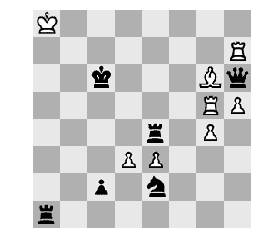

In [64]:
test_image = get_board_image(generate_board())
plt.axis('off')
plt.imshow(test_image);

Новую сеть не обучали, поэтому она распознать ничего не может:

In [65]:
decode_board(predict(model8x8, test_image))

array([['?', '?', '?', '?', '?', '?', '?', '?'],
       ['?', '?', '?', '?', '?', '?', '?', '?'],
       ['?', '?', '?', '?', '?', '?', '?', '?'],
       ['?', '?', '?', '?', '?', '?', '?', '?'],
       ['?', '?', '?', '?', '?', '?', '?', '?'],
       ['?', '?', '?', '?', '?', '?', '?', '?'],
       ['?', '?', '?', '?', '?', '?', '?', '?'],
       ['?', '?', '?', '?', '?', '?', '?', '?']], dtype='<U1')

Копируем веса обученной сети в новую сеть:

In [58]:
def copy_weights(source_model, target_model):
    for i in range(len(source_model.layers)):
        target_model.layers[i].set_weights(source_model.layers[i].get_weights())

In [66]:
copy_weights(model, model8x8)

Теперь изображения шахматных фигур успешно распознаны:

In [67]:
decode_board(predict(model8x8, test_image))

array([['♔', ' ', ' ', ' ', ' ', ' ', ' ', ' '],
       [' ', ' ', ' ', ' ', ' ', ' ', ' ', '♖'],
       [' ', ' ', '♚', ' ', ' ', ' ', '♗', '♛'],
       [' ', ' ', ' ', ' ', ' ', ' ', '♖', '♙'],
       [' ', ' ', ' ', ' ', '♜', ' ', '♙', ' '],
       [' ', ' ', ' ', '♙', '♙', ' ', ' ', ' '],
       [' ', ' ', '♟', ' ', '♞', ' ', ' ', ' '],
       ['♜', ' ', ' ', ' ', ' ', ' ', ' ', ' ']], dtype='<U1')